## üìë Table of Contents

1. [Imports](##imports)
2. [Importing Data](#importing-data)
3. [Checking for Missing Values](#checking-for-missing-values)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Feature Engineering](#feature-engineering)
6. [Feature Importance with SHAP](#feature-importance-with-shap)
6. [Modelling](#modelling)
7. [Evaluation](#evaluation)

## Imports

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf


# Importing Data

In [116]:
data = pd.read_csv('../Datasets/House_Rent_Dataset.csv')
data.head()

Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Contact Owner  
1         1    Contact Owner  
2         1    Contact Owner  
3         1    Contact Owner  
4         1    Contact Owner

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [118]:
# change posted on to date

data['Posted On'] = pd.to_datetime(data['Posted On'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Posted On          4746 non-null   datetime64[ns]
 1   BHK                4746 non-null   int64         
 2   Rent               4746 non-null   int64         
 3   Size               4746 non-null   int64         
 4   Floor              4746 non-null   object        
 5   Area Type          4746 non-null   object        
 6   Area Locality      4746 non-null   object        
 7   City               4746 non-null   object        
 8   Furnishing Status  4746 non-null   object        
 9   Tenant Preferred   4746 non-null   object        
 10  Bathroom           4746 non-null   int64         
 11  Point of Contact   4746 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 445.1+ KB


In [119]:
data.describe()

Posted On          BHK          Rent         Size  \
count                           4746  4746.000000  4.746000e+03  4746.000000   
mean   2022-06-07 18:01:40.126422272     2.083860  3.499345e+04   967.490729   
min              2022-04-13 00:00:00     1.000000  1.200000e+03    10.000000   
25%              2022-05-20 00:00:00     2.000000  1.000000e+04   550.000000   
50%              2022-06-10 00:00:00     2.000000  1.600000e+04   850.000000   
75%              2022-06-28 00:00:00     3.000000  3.300000e+04  1200.000000   
max              2022-07-11 00:00:00     6.000000  3.500000e+06  8000.000000   
std                              NaN     0.832256  7.810641e+04   634.202328   

          Bathroom  
count  4746.000000  
mean      1.965866  
min       1.000000  
25%       1.000000  
50%       2.000000  
75%       2.000000  
max      10.000000  
std       0.884532

In [120]:
# check outliers in rent
Q1 = data['Rent'].quantile(0.25)
Q3 = data['Rent'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

rent_outliers = data[(data['Rent'] < lower_bound) | (data['Rent'] > upper_bound)][['Rent']]
rent_outliers




Rent
104   180000
525    70000
527    75000
530   160000
531   300000
...      ...
4523   70000
4543  200000
4648   80000
4669  140000
4716  110000

[520 rows x 1 columns]

## Checking for Missing Values

In [121]:
data.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

## Check rent distribution

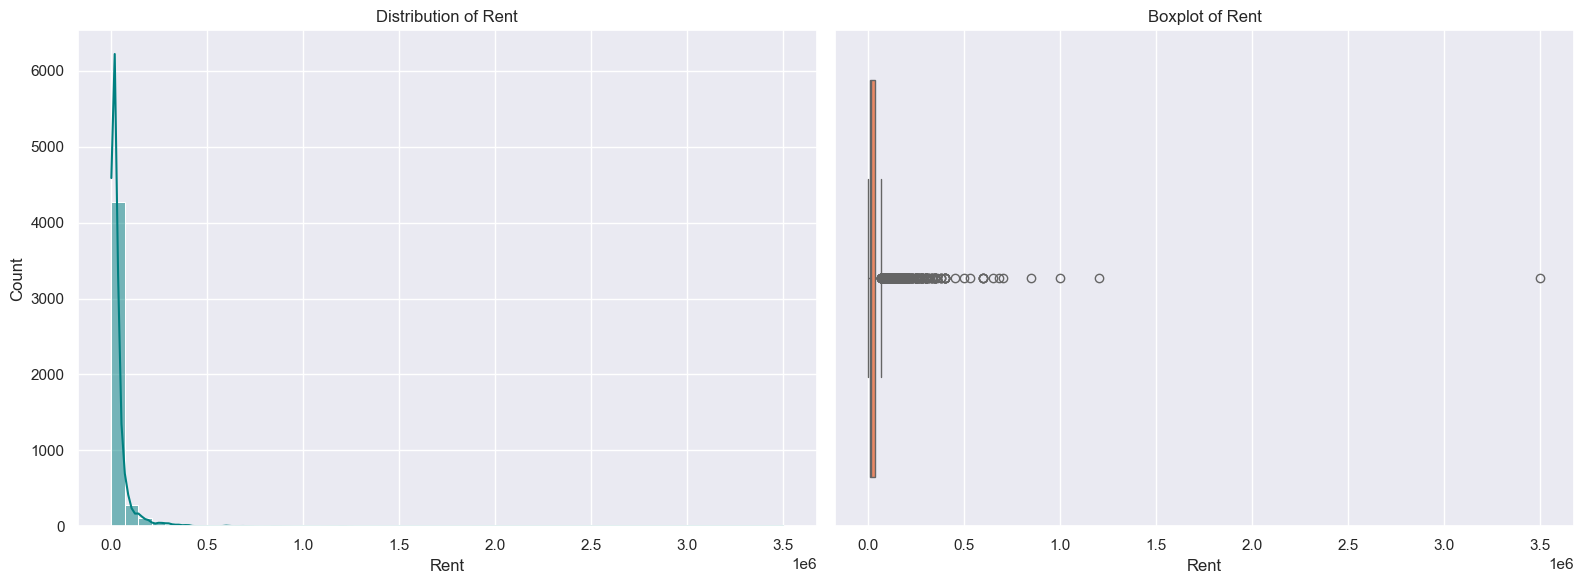

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(data['Rent'], bins=50, kde=True, color='teal', ax=ax[0])
ax[0].set_title("Distribution of Rent")

# Boxplot
sns.boxplot(x=data['Rent'], color='coral', ax=ax[1])
ax[1].set_title("Boxplot of Rent")

plt.tight_layout()
plt.show()


The distribution is highly right skewed 
Make transformation and plot again

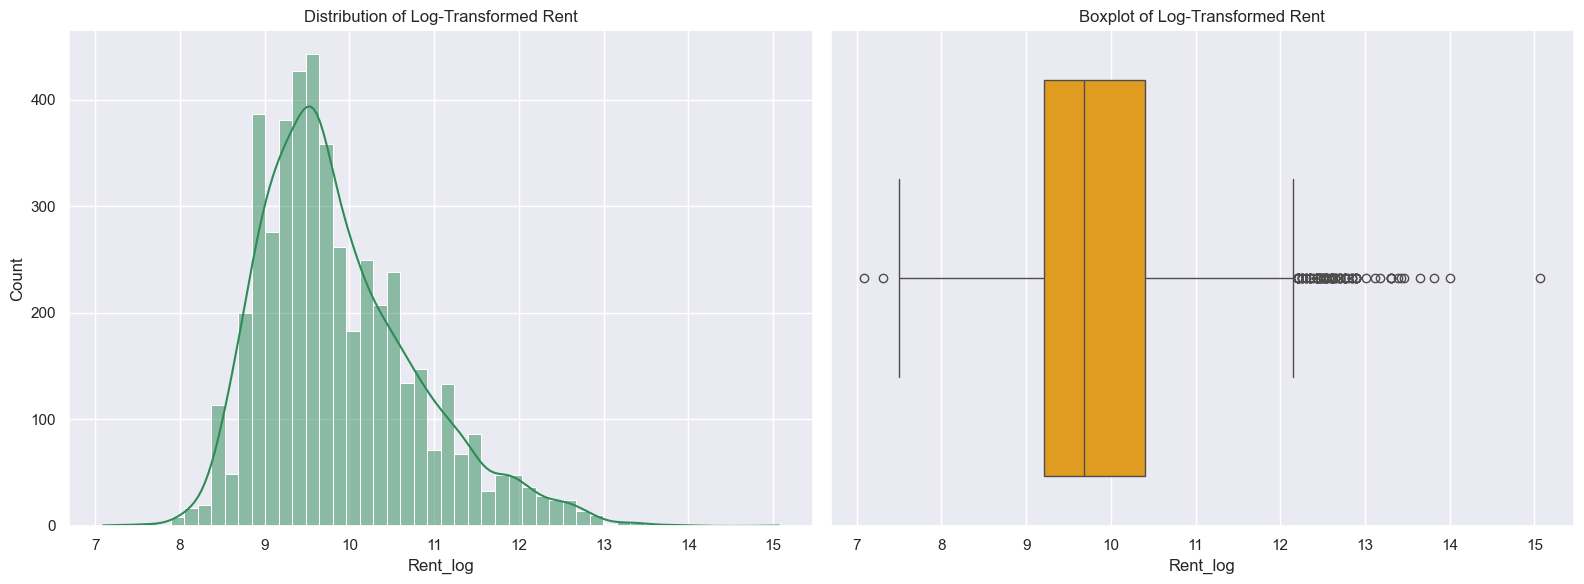

In [123]:
data['Rent_log'] = np.log1p(data['Rent'])

# Plot again
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data['Rent_log'], bins=50, kde=True, color='seagreen', ax=ax[0])
ax[0].set_title("Distribution of Log-Transformed Rent")

sns.boxplot(x=data['Rent_log'], color='orange', ax=ax[1])
ax[1].set_title("Boxplot of Log-Transformed Rent")

plt.tight_layout()
plt.show()

## check Size distribution

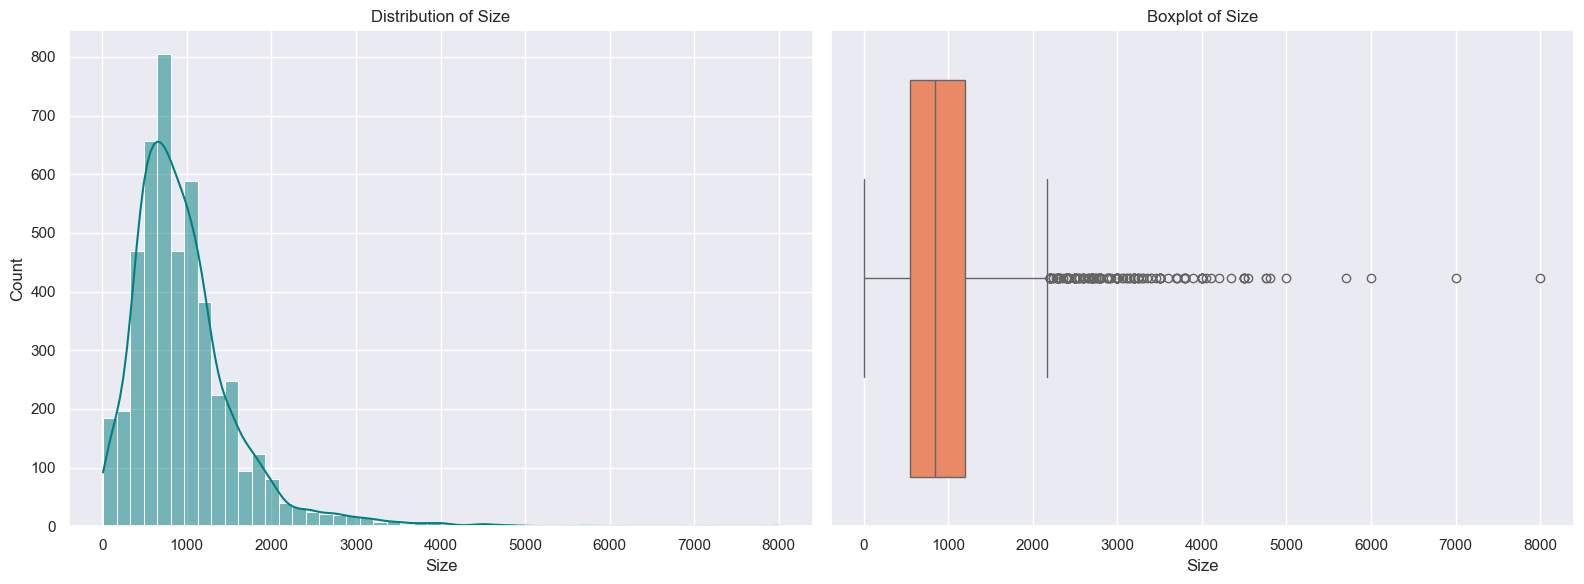

In [124]:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(data['Size'], bins=50, kde=True, color='teal', ax=ax[0])
ax[0].set_title("Distribution of Size")

# Boxplot
sns.boxplot(x=data['Size'], color='coral', ax=ax[1])
ax[1].set_title("Boxplot of Size")

plt.tight_layout()
plt.show()


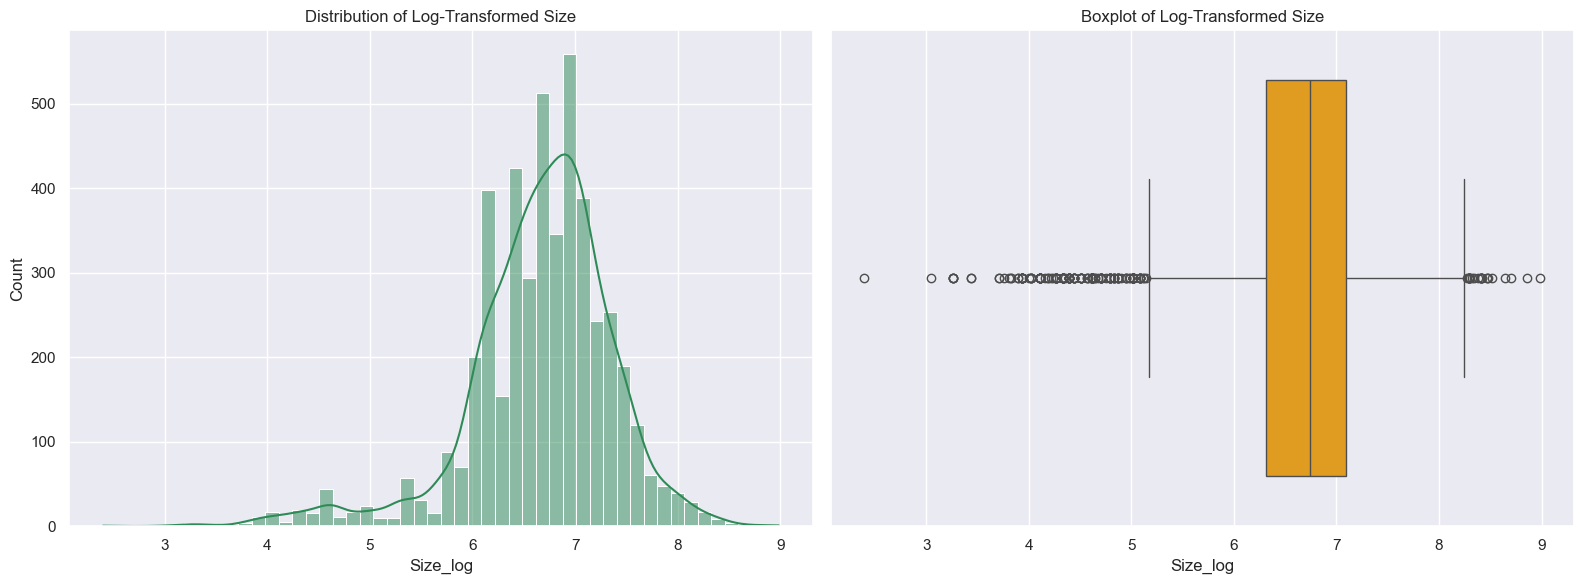

In [125]:
data['Size_log'] = np.log1p(data['Size'])

# Plot again
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data['Size_log'], bins=50, kde=True, color='seagreen', ax=ax[0])
ax[0].set_title("Distribution of Log-Transformed Size")

sns.boxplot(x=data['Size_log'], color='orange', ax=ax[1])
ax[1].set_title("Boxplot of Log-Transformed Size")

plt.tight_layout()
plt.show()

## Exploratory Data Analysis

In [126]:
def plot_rent_by_category(data, category_col, target='Rent'):
    if category_col not in data.columns:
        raise ValueError(f"Column '{category_col}' not found in DataFrame.")
    
    if data[category_col].dtype not in ['object', 'category']:
        print(f"Warning: Column '{category_col}' is not categorical. Proceeding anyway.")

    plt.figure(figsize=(12, 5))
    sns.barplot(x=category_col, y=target, data=data)
    plt.title(f"{target} by {category_col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

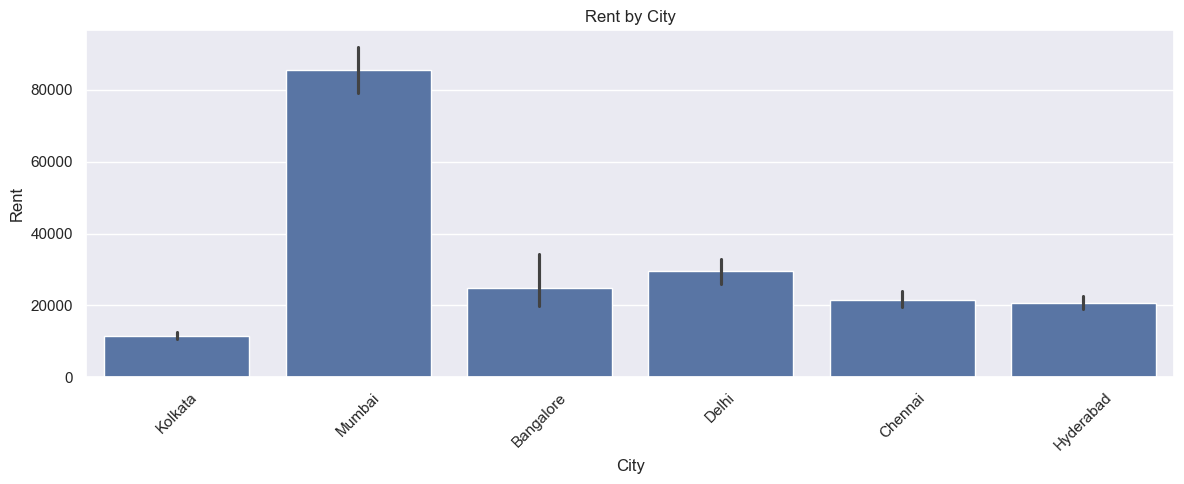

In [127]:
plot_rent_by_category(data,'City')


Mumbai has the highest rent 

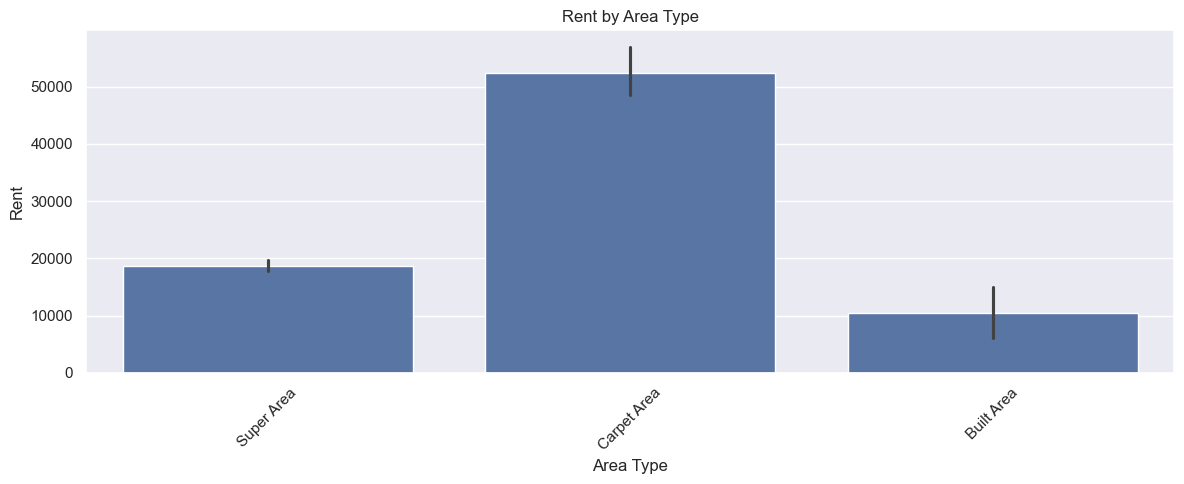

In [128]:
plot_rent_by_category(data,'Area Type')


Carpet area has the highest 

In [129]:
data.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact', 'Rent_log', 'Size_log'],
      dtype='object')

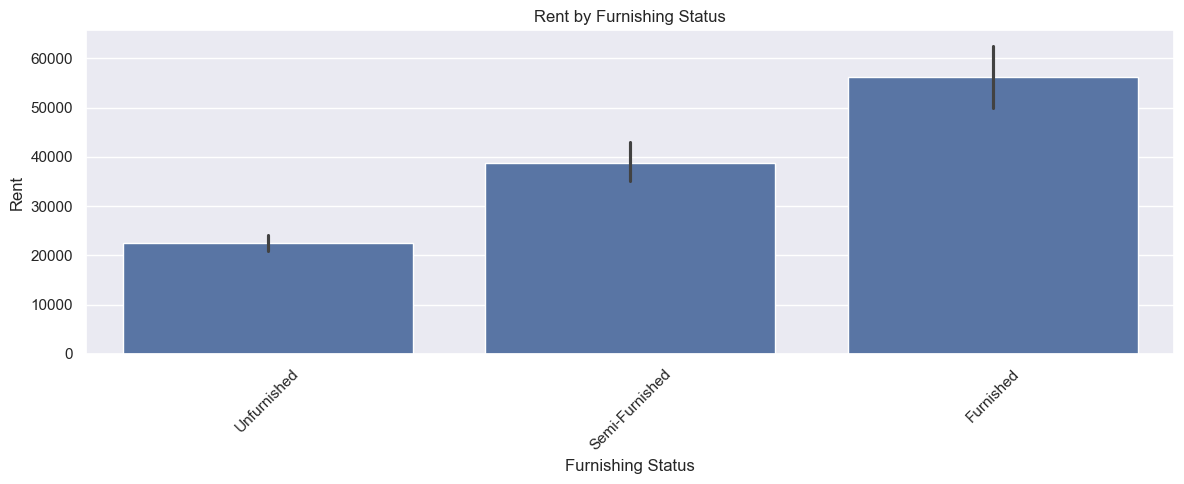

In [130]:
plot_rent_by_category(data,'Furnishing Status')


Furnished has the highest rent folled by semi furnished

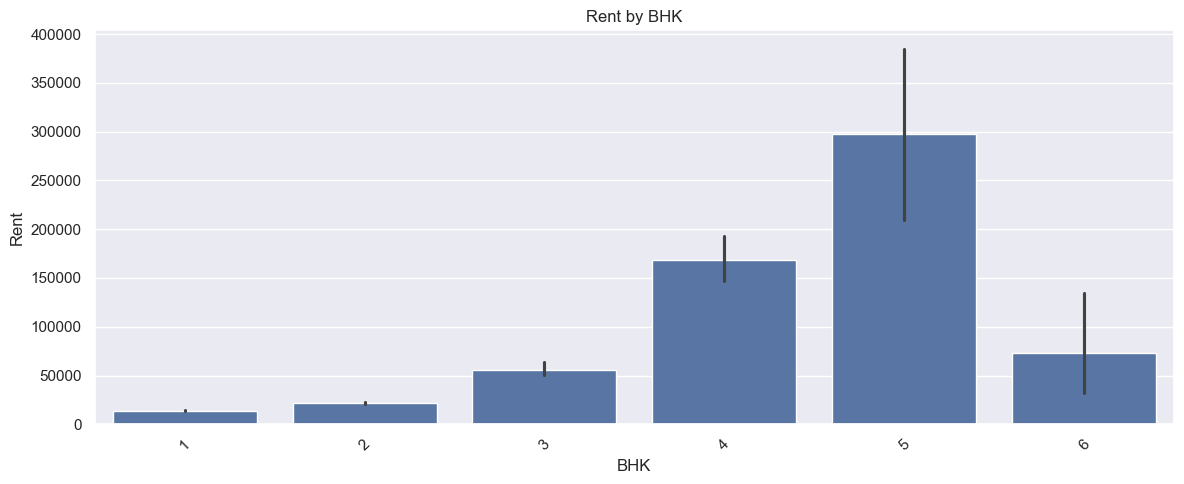

In [131]:
plot_rent_by_category(data,'BHK')


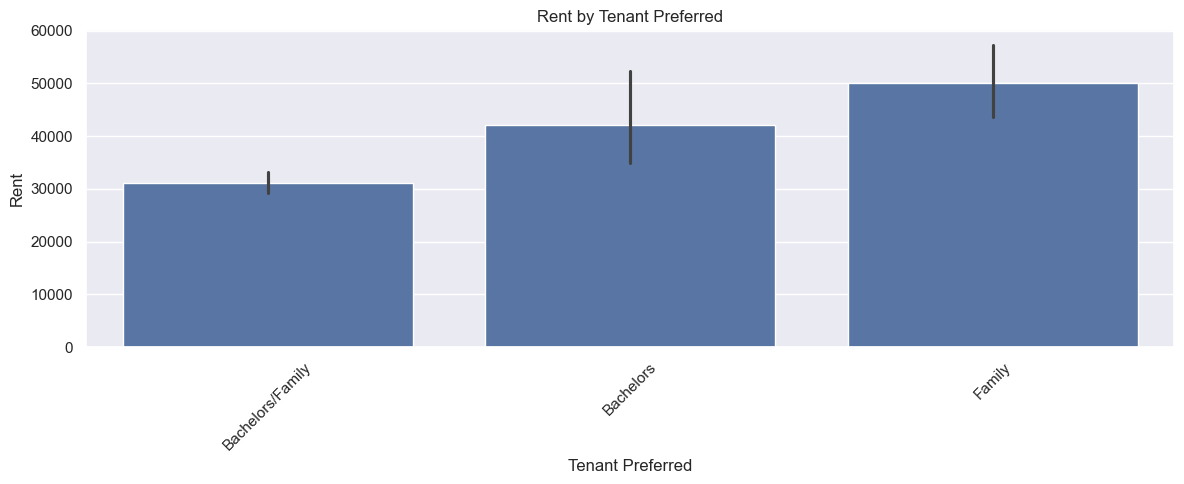

In [132]:
plot_rent_by_category(data,'Tenant Preferred')


Family has the highest rent

C:\Users\abeer.mahmoud\AppData\Local\Temp\ipykernel_45192\937655423.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=data['City'],


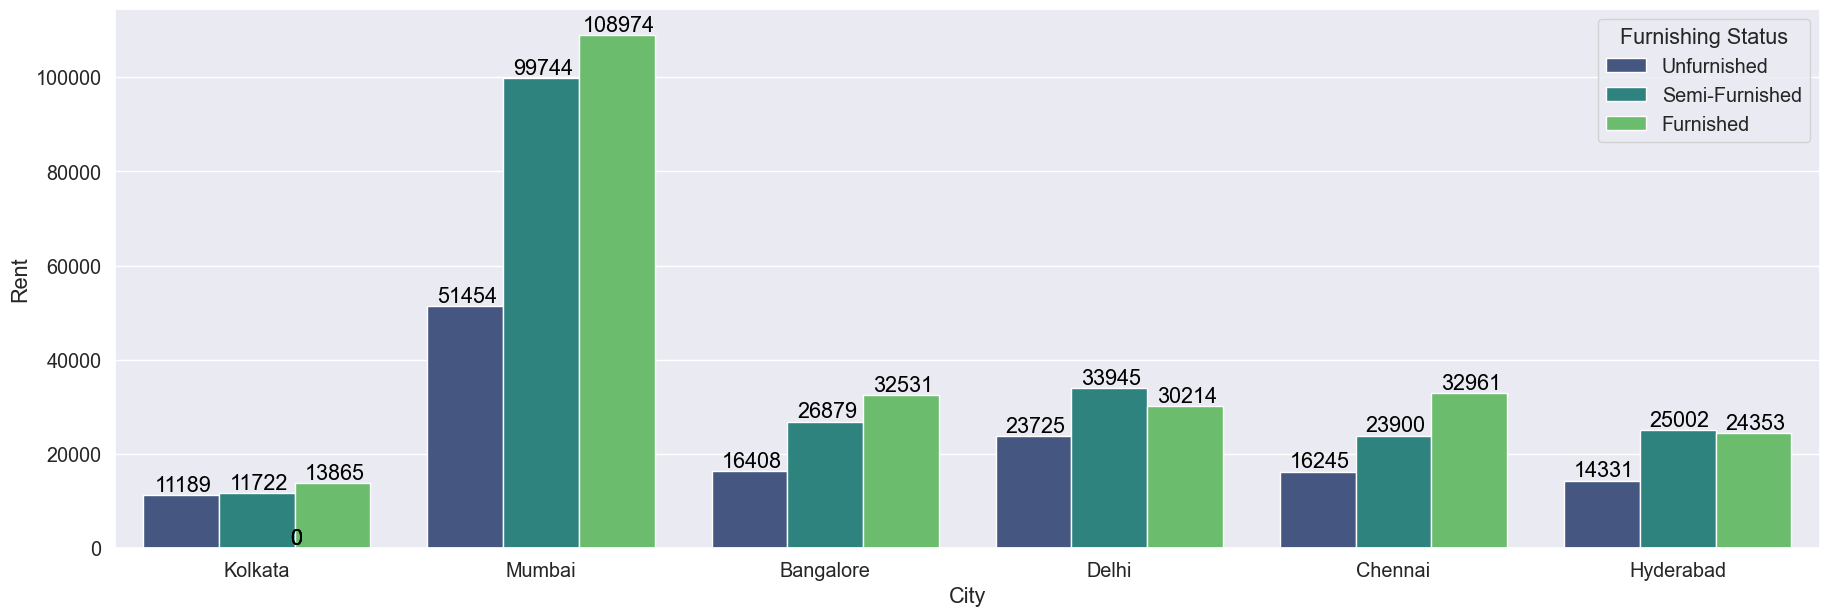

In [133]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=data['City'], 
                 y=data['Rent'],
                 hue = data['Furnishing Status'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.14, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

Furnished Flat has the highest rent (with the exception of Hyderabad).

In [134]:
#cleaning floor variable
data['Floor'] 


0       Ground out of 2
1            1 out of 3
2            1 out of 3
3            1 out of 2
4            1 out of 2
             ...       
4741         3 out of 5
4742         1 out of 4
4743         3 out of 5
4744       23 out of 34
4745         4 out of 5
Name: Floor, Length: 4746, dtype: object

In [135]:
data['Floor_clean'] = data['Floor'].str.replace('Ground', '0', regex=False)
data['Floor_clean'] = data['Floor_clean'].str.extract(r'^(\d+)', expand=False).astype(float)
data.drop(columns='Floor', inplace=True)


In [136]:
missing = X.isna().sum()
print(missing[missing > 0])
data["Floor_clean"]
data['Floor_clean'].fillna(data['Floor_clean'].median(), inplace=True)

Series([], dtype: int64)


C:\Users\abeer.mahmoud\AppData\Local\Temp\ipykernel_45192\161601380.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Floor_clean'].fillna(data['Floor_clean'].median(), inplace=True)


In [137]:
data.columns
data.drop(columns='Area Locality', inplace=True)


In [138]:
data = (
    data.assign(
        month_posted = data['Posted On'].dt.month,
        day_posted = data['Posted On'].dt.day,
        weekday_posted = data['Posted On'].dt.dayofweek,
        quarter_posted = data['Posted On'].dt.quarter
    )
    .drop(columns='Posted On')
)


In [139]:
columns = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']

for col in columns:
    dummies = pd.get_dummies(data[col], prefix=col, drop_first=True)
    data = pd.concat([data.drop(columns=col), dummies], axis=1)


In [140]:
X = data.drop(['Rent', 'Rent_log'], axis=1)  # drop both to prevent the data leakage
y = data['Rent_log']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [141]:
X.select_dtypes(include='object').columns


Index([], dtype='object')

## Feature Importance with SHAP

In [ ]:
#!pip install shap
import xgboost as xgb
import shap

X = data.drop(['Rent', 'Rent_log'], axis=1)
y = data['Rent_log']

model = xgb.XGBRegressor()
model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [143]:
# Initialize SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X)


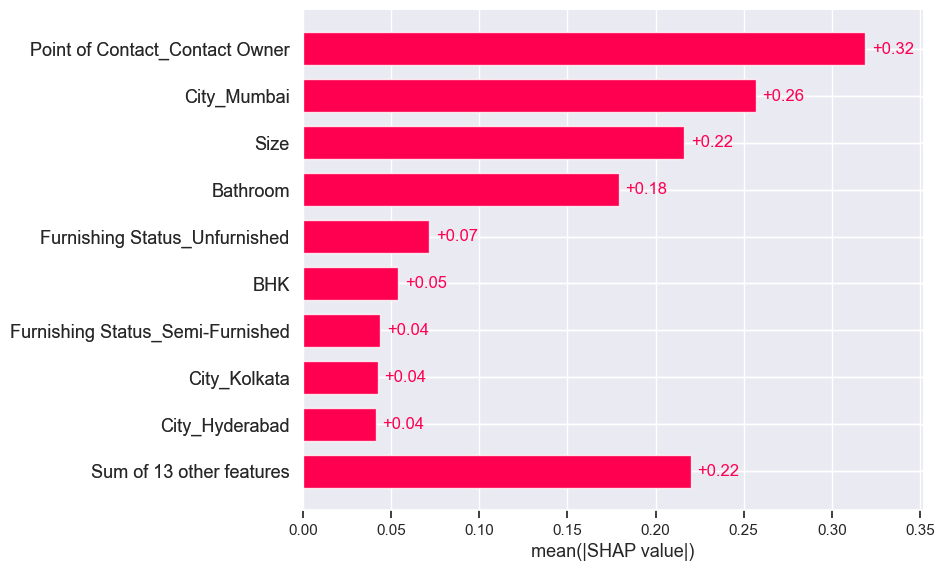

In [144]:
shap.plots.bar(shap_values)


## Modelling

In [145]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'bayesian ridge' : BayesianRidge(),
    'support vector': SVR(),
    'knn' : KNeighborsRegressor(n_neighbors = 4)
}

In [146]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
catboost trained
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 3796, number of used features: 21
[LightGBM] [Info] Start training from score 9.879274
lightgbm trained
gradient boosting trained
lasso trained
random forest trained
bayesian ridge trained
support vector trained
knn trained


In [150]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(20))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss = 'mse', 
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
119/119 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - loss: 70.4312 - rmse: 8.2981 - val_loss: 0.4156 - val_rmse: 0.6446
Epoch 2/50
119/119 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 16.5261 - rmse: 3.5667 - val_loss: 0.1757 - val_rmse: 0.4191
Epoch 3/50
119/119 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 3.5488 - rmse: 1.3970 - val_loss: 0.8456 - val_rmse: 0.9196
Epoch 4/50
119/119 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 6.3681 - rmse: 2.2647 - val_loss: 0.1785 - val_rmse: 0.4225
Epoch 5/50
119/119 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.2490 - rmse: 0.4833 - val_loss: 0.2815 - val_rmse: 0.5305
Epoch 6/50
119/119 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.2304 - rmse: 0.4783 - val_loss: 0.1487 - val_rmse: 0.3856
Epoch 7/50
119/119 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [151]:
RMSE_ann = model.evaluate(X_test, y_test)[1]
RMSE_ann

30/30 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.1824 - rmse: 0.4268


0.42042285203933716

In [157]:
results = {}
kf = KFold(n_splits= 10)
for name, model in models.items():
    result = np.mean(
        np.sqrt(
            -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
        )
    )
    results[name] = result


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 3416, number of used features: 21
[LightGBM] [Info] Start training from score 9.881248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 3416, number of used features: 21
[LightGBM] [Info] Start training from score 9.881728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [159]:
for name, result in results.items():
    print(f"{name} : {round(result, 3)}")

ridge : 0.409
xgboost : 0.414
catboost : 0.389
lightgbm : 0.409
gradient boosting : 0.397
lasso : 0.938
random forest : 0.411
bayesian ridge : 0.409
support vector : 0.396
knn : 0.458


In [160]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df.T

lasso       knn  xgboost  random forest     ridge  bayesian ridge  \
RMSE  0.937808  0.458168  0.41376        0.41058  0.408672        0.408662   

      lightgbm  gradient boosting  support vector  catboost  
RMSE  0.408523           0.396814        0.396133  0.389113

In [149]:
data.columns

Index(['BHK', 'Rent', 'Size', 'Bathroom', 'Rent_log', 'Size_log',
       'Floor_clean', 'month_posted', 'day_posted', 'weekday_posted',
       'quarter_posted', 'Area Type_Carpet Area', 'Area Type_Super Area',
       'City_Chennai', 'City_Delhi', 'City_Hyderabad', 'City_Kolkata',
       'City_Mumbai', 'Furnishing Status_Semi-Furnished',
       'Furnishing Status_Unfurnished', 'Tenant Preferred_Bachelors/Family',
       'Tenant Preferred_Family', 'Point of Contact_Contact Builder',
       'Point of Contact_Contact Owner'],
      dtype='object')

## Evaluation

C:\Users\abeer.mahmoud\AppData\Local\Temp\ipykernel_45192\29923109.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')


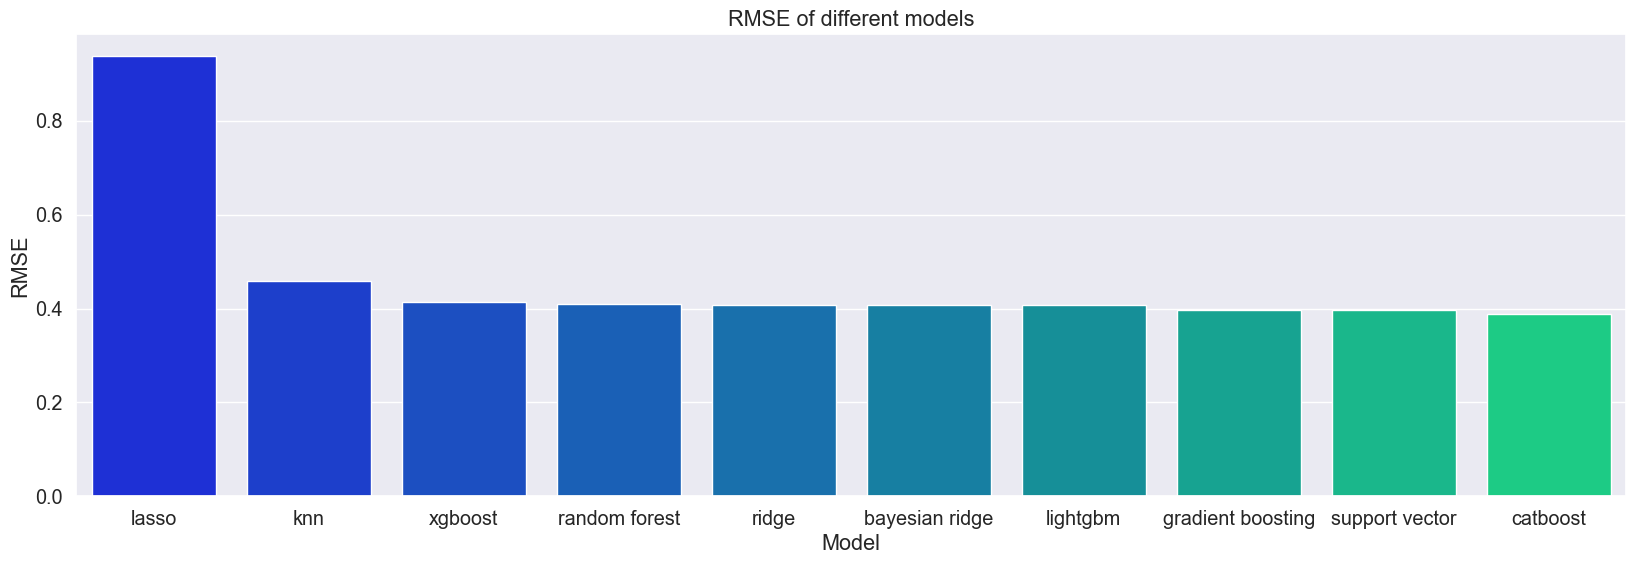

In [163]:
plt.figure(figsize = (20, 6))
sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');

In [165]:

final_predictions = (
    0.20 * np.expm1(models['catboost'].predict(X_test)) +
    0.20 * np.expm1(models['support vector'].predict(X_test)) +
    0.20 * np.expm1(models['lightgbm'].predict(X_test)) + 
    0.20 * np.expm1(models['random forest'].predict(X_test)) + 
    0.20 * np.expm1(models['gradient boosting'].predict(X_test))
)


In [166]:
# Inverse-transform y_test
y_test_actual = np.expm1(y_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_actual, final_predictions))
r2 = r2_score(y_test_actual, final_predictions)

print(f'RMSE: {rmse}')
print(f'R-square: {r2}')

RMSE: 35166.86828079207
R-square: 0.6896887584258136


R squared is 70% 